## Electricity price prediction for NYC

In [1]:
import pandas as pd

import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
df_price = pd.read_csv('nyiso_price_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_load = pd.read_csv('nyiso_load_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])

In [3]:
df_price.shape, df_load.shape

((113161, 3), (106168, 3))

In [4]:
may1st_index_price = df_price.time_stamp_local >= pd.datetime(2017, 5, 1)
may1st_index_load = df_load.time_stamp_local >= pd.datetime(2017, 5, 1)

In [5]:
df_price = df_price.loc[may1st_index_price, :]
df_load = df_load.loc[may1st_index_load, :]

In [6]:
df_price.shape, df_load.shape

((78307, 3), (78307, 3))

In [7]:
df_price.head(2)

,time_stamp,lbmp_price,time_stamp_local
34854,2017-05-01 04:00:00,15.28,2017-05-01 00:00:00
34855,2017-05-01 04:05:00,14.21,2017-05-01 00:05:00


In [8]:
df_load.head(2)

,time_stamp,load,time_stamp_local
27861,2017-05-01 04:00:00,4432.2,2017-05-01 00:00:00
27862,2017-05-01 04:05:00,4388.2,2017-05-01 00:05:00


In [9]:
# df_nyiso['lbmp_price_log1p'] = df_nyiso.lbmp_price.apply(lambda x : np.log1p(x) if x >= 0. else 0.)

In [10]:
standardizer_price = preprocessing.StandardScaler()
#standardizer_price = preprocessing.MinMaxScaler()
df_price['lbmp_price_scaled'] = standardizer_price.fit_transform(df_price.lbmp_price.values.reshape(-1, 1))

In [11]:
standardizer_load = preprocessing.StandardScaler()
#standardizer_load = preprocessing.MinMaxScaler()
df_load['load_scaled'] = standardizer_load.fit_transform(df_load.load.values.reshape(-1, 1))

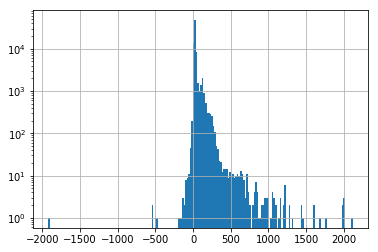

In [12]:
df_price.lbmp_price.hist(bins = 200, log = True)

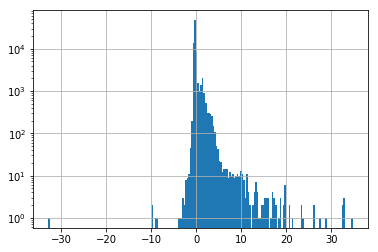

In [13]:
df_price.lbmp_price_scaled.hist(bins = 200, log = True)

In [14]:
# df_price['lbmp_price_scaled'] = preprocessing.scale(df_price.lbmp_price)
# df_load['load_scaled'] = preprocessing.scale(df_load.load)

In [15]:
# df_nyiso['lbmp_price_log1p_scaled'] = preprocessing.scale(df_nyiso.lbmp_price_log1p)

In [16]:
df_price.head(2)

,time_stamp,lbmp_price,time_stamp_local,lbmp_price_scaled
34854,2017-05-01 04:00:00,15.28,2017-05-01 00:00:00,-0.406933
34855,2017-05-01 04:05:00,14.21,2017-05-01 00:05:00,-0.424837


In [17]:
df_load.head(2)

,time_stamp,load,time_stamp_local,load_scaled
27861,2017-05-01 04:00:00,4432.2,2017-05-01 00:00:00,-1.369102
27862,2017-05-01 04:05:00,4388.2,2017-05-01 00:05:00,-1.403841


In [18]:
def feature_target_split(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
        except:
            break
        X.append(x_i)
        Y.append(y_i)
    return X, Y

In [19]:
def shuffle_Xy(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [20]:
def train_test_ts_split(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_Xy(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

In [3]:
TRAIN_SIZE = 12 * 24 * 2
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

In [22]:
len(df_price.lbmp_price_scaled.values), len(df_load.load_scaled.values)

(78307, 78307)

In [23]:
df_price.lbmp_price_scaled.head()

34854   -0.406933
34855   -0.424837
34856   -0.464994
34857   -0.407101
34858   -0.407101
Name: lbmp_price_scaled, dtype: float64

In [24]:
# df_price.set_index('time_stamp', inplace = True)
# df_load.set_index('time_stamp', inplace = True)

# df_load_new = df_load.reindex(df_price.index)

# df_load_new.load.fillna(0., inplace = True)
# df_load_new.load_scaled.fillna(0., inplace = True)

# sum(df_load_new.load.isnull())

# set(df_price.index.values) - set(df_load_new.index.values)

In [25]:
# fig, ax = plt.subplots(figsize = (16, 9))
# ax.plot(df_price.time_stamp, df_price.lbmp_price_scaled, label = 'price')
# ax.plot(df_load.time_stamp, df_load.load_scaled, label = 'load')
# ax.legend()

In [26]:
X, Y = feature_target_split(df_load.load_scaled.values, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_ts_split(X, Y, percentage=0.9)

Xp, Yp = feature_target_split(df_price.lbmp_price_scaled.values, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = train_test_ts_split(Xp, Yp, percentage=0.9)

In [27]:
# model = Sequential()
# model.add(Dense(2000, input_shape = (TRAIN_SIZE, )))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1000))
# model.add(Activation('relu'))
# model.add(Dense(1))
# model.add(Activation('linear'))
# model.compile(optimizer='adam', 
#               loss='mse')

# model.fit(X_train, 
#           Y_train, 
#           nb_epoch=5, 
#           batch_size = 128, 
#           verbose=1, 
#           validation_split=0.1)
# score = model.evaluate(X_test, Y_test, batch_size=128)

In [28]:
# predicted = model.predict(X_test)
# try:
#     fig = plt.figure(figsize=(16, 9))
#     plt.plot(Y_test[:1000], color='black')
#     plt.plot(predicted[:1000], color='blue')
#     plt.show()
# except Exception as e:
#     print(str(e))

In [29]:
# score

In [4]:
model2 = Sequential()
model2.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(250))
model2.add(Activation('relu'))
model2.add(Dense(1))
model2.add(Activation('linear'))
model2.compile(optimizer='adam', 
              loss='mse')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               288500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total para

In [30]:
model2.fit(X_trainp, 
          Y_trainp, 
          nb_epoch=6, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score2 = model2.evaluate(X_testp, Y_testp, batch_size=128)

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 62961 samples, validate on 6996 samples
Epoch 1/6
62961/62961 [==============================] - 9s 147us/step - loss: 0.3656 - val_loss: 0.3000
Epoch 2/6
62961/62961 [==============================] - 9s 150us/step - loss: 0.2842 - val_loss: 0.3058
Epoch 3/6
62961/62961 [==============================] - 9s 151us/step - loss: 0.2691 - val_loss: 0.2730
Epoch 4/6
62961/62961 [==============================] - 10s 151us/step - loss: 0.2560 - val_loss: 0.2754
Epoch 5/6
62961/62961 [==============================] - 10s 151us/step - loss: 0.2440 - val_loss: 0.2953
Epoch 6/6
7773/7773 [==============================] - 0s 43us/step


In [33]:
np.sqrt(score2) * np.std(df_price.lbmp_price.values)

88.778583420789005

In [37]:
predicted2 = model2.predict(X_testp)
y_price_pred = standardizer_price.inverse_transform(predicted2)
y_price_valid = standardizer_price.inverse_transform(Y_testp)
np.sqrt(mean_squared_error(y_price_pred, y_price_valid))

88.778579586064254

In [44]:
len(Yp), len(y_price_valid), df_price.shape[0] * 0.1

(77730, 7773, 7830.700000000001)

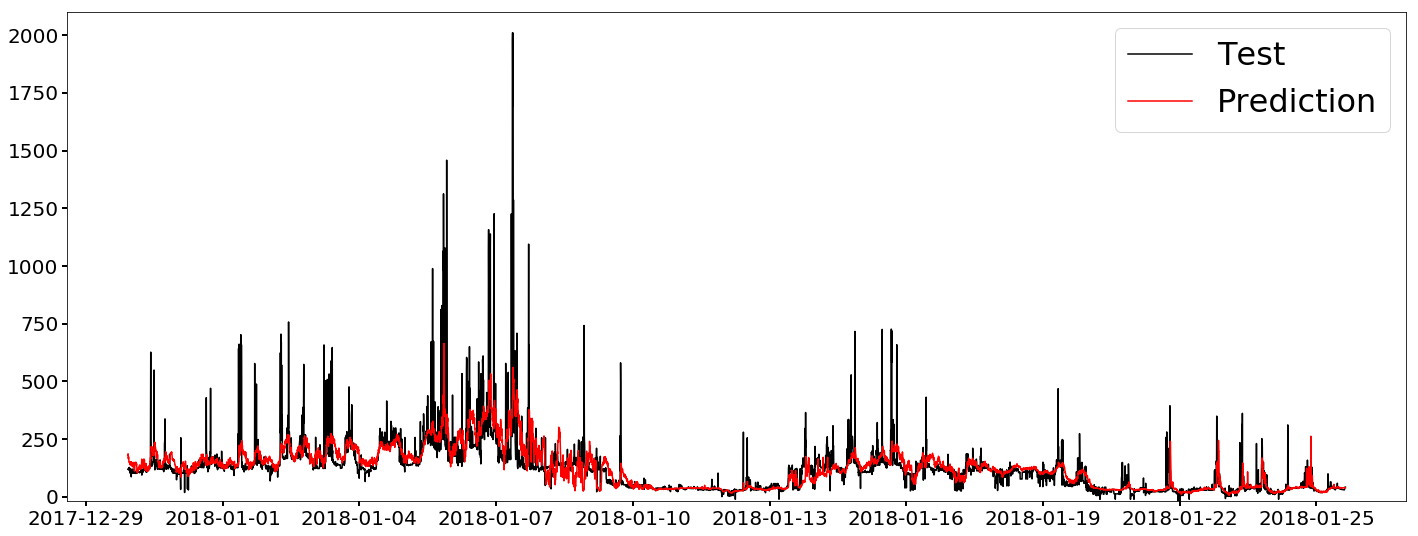

In [70]:
predicted2 = model2.predict(X_testp)
try:
    fig, ax = plt.subplots(figsize=(24, 9))
#     plt.plot(Y_testp[:1000], color='black')
#     plt.plot(predicted2[:1000], color='blue')
    ax.plot(df_price.time_stamp_local.iloc[df_price.shape[0] - len(y_price_valid):], 
            y_price_valid, color = 'black', label = 'Test')
    ax.plot(df_price.time_stamp_local.iloc[df_price.shape[0] - len(y_price_pred):], 
            y_price_pred, color = 'red', label = 'Prediction')
    ax.tick_params(axis='both',which='both',labelsize=20,
        length=5,width=2,direction='out');
    ax.set_ylim(-20, 2100);
    ax.legend(fontsize = 32)
    plt.savefig('mlp_2017.pdf', format = 'pdf')
except Exception as e:
    print(str(e))

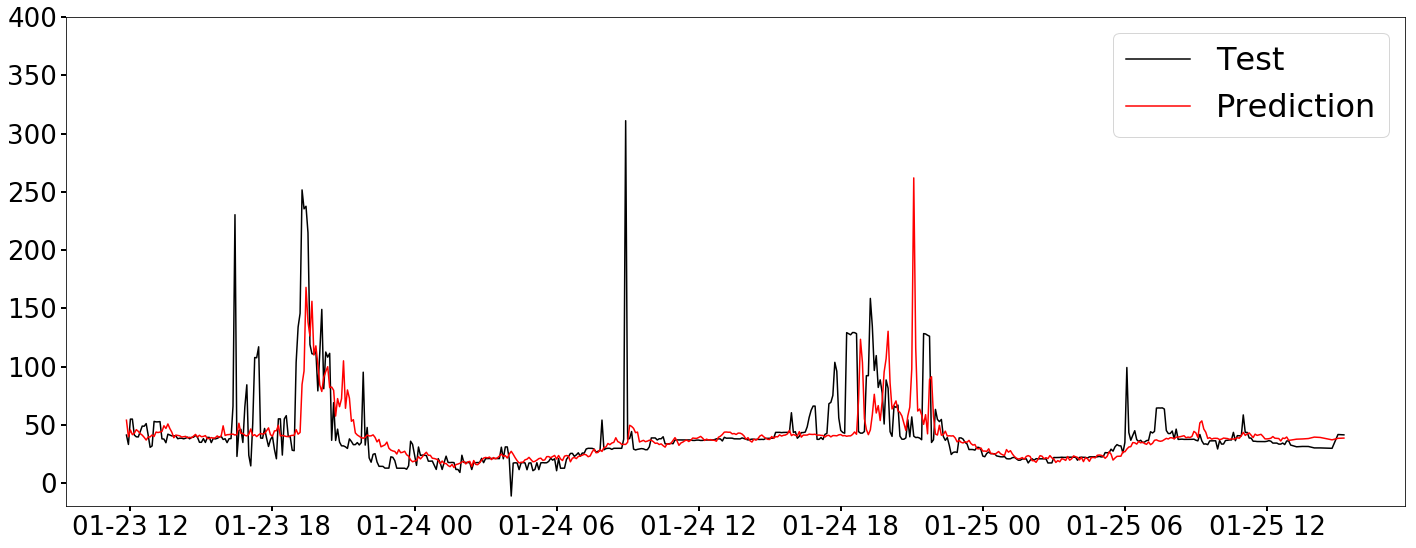

In [74]:
if 1 == 1:
    fig, ax = plt.subplots(figsize=(24, 9))
#     plt.plot(Y_testp[:1000], color='black')
#     plt.plot(predicted2[:1000], color='blue')
    ax.plot(df_price.time_stamp_local.iloc[df_price.shape[0] - 600:], 
            y_price_valid[len(y_price_valid) - 600:], color = 'black', label = 'Test')
    ax.plot(df_price.time_stamp_local.iloc[df_price.shape[0] - 600:], 
            y_price_pred[len(y_price_valid) - 600:], color = 'red', label = 'Prediction')
    ax.tick_params(axis='both',which='both',labelsize=26,
        length=5,width=2,direction='out');
    ax.set_ylim(-20, 400);
    ax.legend(fontsize = 32)
    plt.savefig('mlp_2017_small.pdf', format = 'pdf')